# Predicting Spotify hits with Machine Learning

Objective : 
Predicting spotify hits using supervised machine learning algorithms 

Context :
Every music producer wants to put the track that has the best chance of becoming a hit at the first posoition of the album.
But how do you know if the song has a chance of becoming a hit?

Music tracks can be analyzed using a large number of parameters such as their key, the level of danceability, the acousticness, they duration, etc. By analyzing these parameters and trying to find the best supervised machine learning model, we can try to predict which tracks have the most potential to become a hit.

Data :
This is a dataset consisting of features for tracks fetched using Spotify's Web API. I took only the smaller version of it from Kaggle.
The tracks are labeled '1' or '0' ('Hit' or 'No hit') depending on some criterias of the author.

The author's condition of a track being "No hit" is as follows:
- The track must not appear in the 'hit' list of that decade.
- The track's artist must not appear in the 'hit' list of that decade.
- The track must belong to a genre that could be considered non-mainstream and / or avant-garde.
- The track's genre must not have a song in the 'hit' list.
- The genre list for the particular decades are as follows:
- The track must have 'US' as one of its markets.

Method :
As we want to predict which class a track is part of which (hit or no hit), we will use classification algorithms.

Process:
1. Data manipulation
2. Exploratory data analysis 
3. Supervised learning
4. Supervised learning with PCA
5. Summary

In [313]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats.mstats import winsorize
import shap
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

# 1. Data manipulation

There are 6 csv files in the current version of the dataset; each of them contains from 5300 tà 7400 tracks and their attributes for a specific decade.

In [415]:
def read_df():
    """Function reading the 6 datasets, concating them and creating a decade column"""
    data=pd.DataFrame()
    years=[6,7,8,9,0,1]
    for i in years:
        year=str(i)
        path='/Users/borispetelle/Documents/GitHub/Projects/Spotify Hit Prediction/the-spotify-hit-predictor-dataset/dataset-of-'
        decade=int(year) if int(year)>1 else int('1'+year)
        df=pd.read_csv(path+year+'0s.csv')
        df['decade']=decade
        data=data.append(df)
    return data.reset_index(drop=True)

df = read_df()
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Jealous Kind Of Fella,Garland Green,spotify:track:1dtKN6wwlolkM8XZy2y9C1,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173533,3,32.94975,9,1,6
1,Initials B.B.,Serge Gainsbourg,spotify:track:5hjsmSnUefdUqzsDogisiX,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0,6
2,Melody Twist,Lord Melody,spotify:track:6uk8tI6pwxxdVTNlNOJeJh,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223960,4,37.22663,12,0,6
3,Mi Bomba Sonó,Celia Cruz,spotify:track:7aNjMJ05FvUXACPWZ7yJmv,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157907,4,24.75484,8,0,6
4,Uravu Solla,P. Susheela,spotify:track:1rQ0clvgkzWr001POOPJWx,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245600,4,21.79874,14,0,6


All the variables are numeric data, except track, artist and uri. 

Both artist and track columns contain unique values. I decided to keep them.\
As uri provides no relevant information and contains unique values, I decided to drop the column.

In [416]:
def drop_columns(df,column):
    "Function dropping chosen columns in the dataframe"
    df.drop(column,axis=1,inplace=True)
    return df

# Drop uri column
drop_columns(df,'uri')
df.head()

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade
0,Jealous Kind Of Fella,Garland Green,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173533,3,32.94975,9,1,6
1,Initials B.B.,Serge Gainsbourg,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213613,4,48.82510,10,0,6
2,Melody Twist,Lord Melody,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223960,4,37.22663,12,0,6
3,Mi Bomba Sonó,Celia Cruz,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157907,4,24.75484,8,0,6
4,Uravu Solla,P. Susheela,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245600,4,21.79874,14,0,6


There are no missing values. 

In [249]:
df.isna().sum()

track               0
artist              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
decade              0
dtype: int64

The majority of the variables are well standardized or normalized.\
However, we can see that the duration, the tempo and the chorus_hit will probably have to be standardize or normalized while building our models.

In [413]:
df[[i for i in df.columns]].describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
danceability,41106.0,0.5,0.2,0.0,0.4,0.6,0.7,1.0
energy,41106.0,0.6,0.3,0.0,0.4,0.6,0.8,1.0
key,41106.0,5.2,3.5,0.0,2.0,5.0,8.0,11.0
loudness,41106.0,-10.2,5.3,-49.3,-12.8,-9.3,-6.4,3.7
mode,41106.0,0.7,0.5,0.0,0.0,1.0,1.0,1.0
speechiness,41106.0,0.1,0.1,0.0,0.0,0.0,0.1,1.0
acousticness,41106.0,0.4,0.3,0.0,0.0,0.3,0.7,1.0
instrumentalness,41106.0,0.2,0.3,0.0,0.0,0.0,0.1,1.0
liveness,41106.0,0.2,0.2,0.0,0.1,0.1,0.3,1.0
valence,41106.0,0.5,0.3,0.0,0.3,0.6,0.8,1.0


We can see that we have some outliers:

For the duration_ms :  I decided tocreate dummies for long and short tracks.

In [277]:
df['long_track'] = df.duration_ms.apply(lambda x : 1 if x>np.percentile(df.duration_ms,95) else 0)

In [278]:
df['short_track'] = df.duration_ms.apply(lambda x : 1 if x<np.percentile(df.duration_ms,5) else 0)

# 2. Exploratory Data Analysis

With the heatmap, we can see if some of our features are highly correlated.\
Duration and sections are highly correlated, I will drop sections while building models.\
All other features are not exceeded 85% of correlation. I can keep all of them.

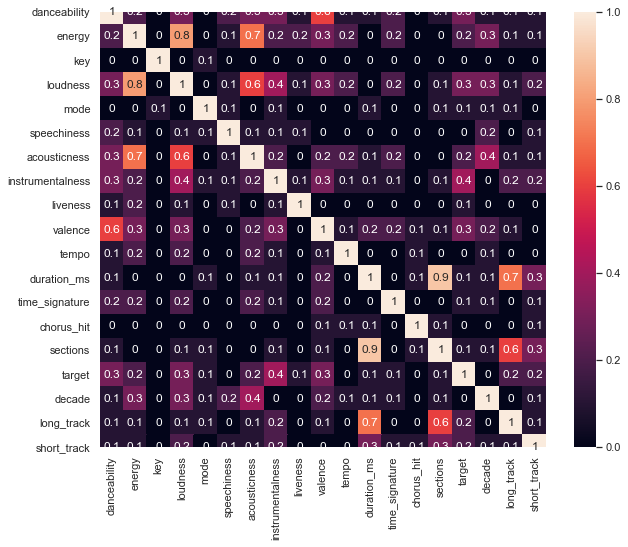

In [279]:
plt.figure(figsize=(10,8))
corr_heatmap = sns.heatmap(abs(df.corr()).round(1),annot=True)
plt.show()

Lets look at the distribution of the data between tracks that became hits and those who don't regarding their features.\
Thanks to this visualization, we can make some observations.
Compared to tracks that do not become hits, the hits :
- have a high level danceability 
- have a high level of energy 
- have a loundness between [5:15] 
- are not too accoustic 
- have a high level of positivness (valance) 
- are around 4 minutes
- have 4 beats per bar/measure 
- have their chorus starting at the very beginging of the song 
- have an average sections close to 10

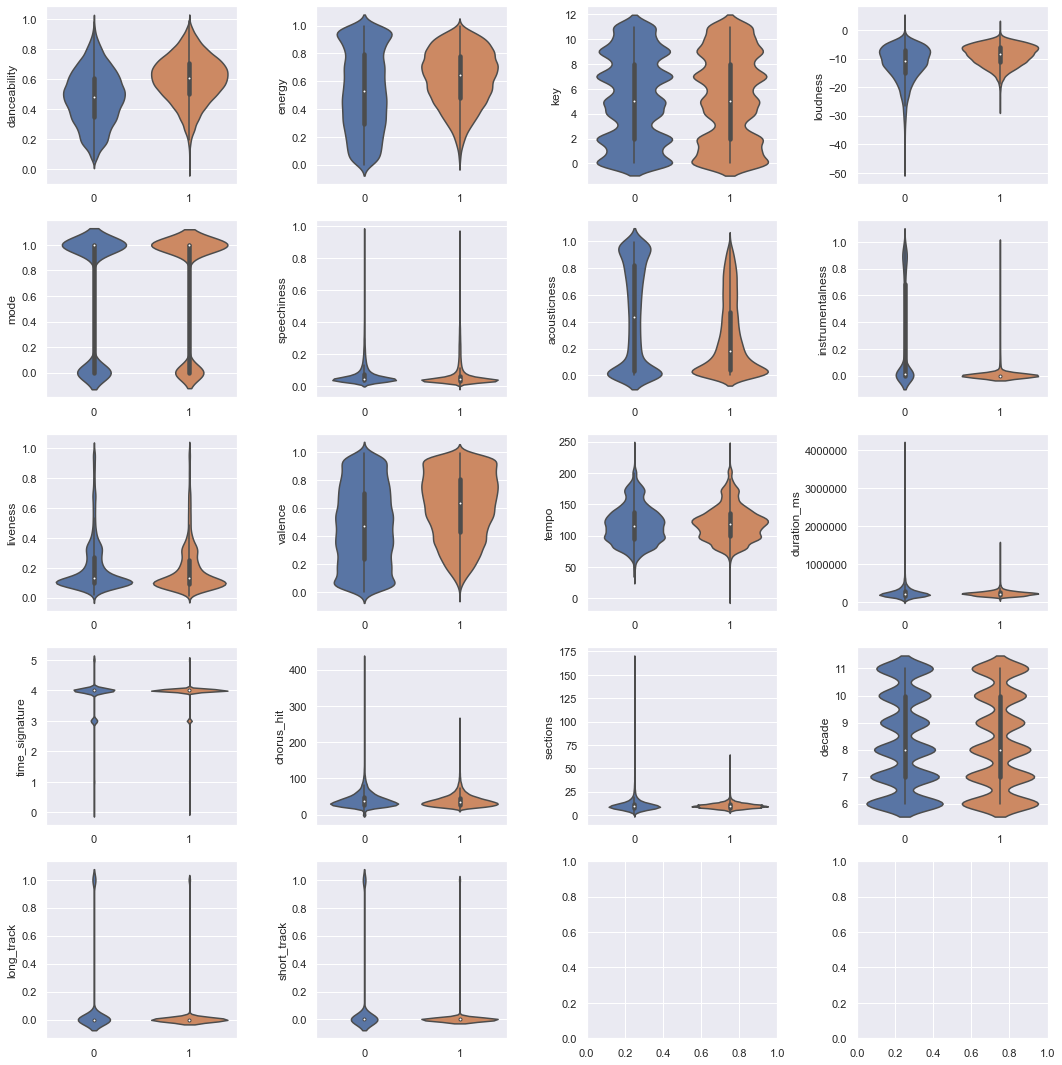

In [280]:
# Violin plots to analyse the distribution of hits and no hits regarding their features
numerical = list(df._get_numeric_data().drop('target',axis=1).columns)
fig, axes=plt.subplots(nrows=5, ncols=4, figsize=(15,15))
for idx, feat in enumerate(numerical):
    ax=axes[int(idx/4), idx%4]
    sns.violinplot(x='target',y=feat, data=df, ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel(feat)
fig.tight_layout();

# 3. Supervized learning models

Let's build different prediction models and test which one is the best between:
    1. Logistic Regression
    2. K Nearest Neighbors
    3. Support Vector Machine
    4. Decision trees
    5. Random forests
    6. Naive Bayes
    7. Catboost

In classification models, we look at the following metrics:
- Confusion matrix : summary of prediction for true negative, false positive, false negative and false positive
- AUC score : degree or measure of separability
- Accuracy : how much time our prediction matched
- Precision : proportion of positive prediction that were correctly classify 
- Recall : proportion of positive samples that were correctly classify 
- F1-score : average value between precision and recall 

There are two types of possible errors:
- False Negative : I predicted that the track was not becoming a hit and it did
- False Positive : I predicted that the track was becoming a hit but it didn't 

In the first case, it is a lost of opportunity for my client ; because of my bad prediction, he missed a hit.\
In the second case, it is a lost of money for my client ; telling him that this song was going to be a hit, he put it on the album first, so he put more money on it but it didn't become a hit.\
My primary objective is not to cause my client to lose money and therefore to reduce the False Positive.\
So the most important measurement when comparing my models is "Prediction". 

# 3.1 Logistic regression 

# 1st model 
- Without feature engineering

In [316]:
X1 = df.drop(['track','artist','target','sections'],axis=1).copy()
y = df.target.copy()

In [317]:
X1_train, X1_test, y_train, y_test = train_test_split(X1,y,test_size=0.33, stratify=y)

In [318]:
# Model 1
model1 = LogisticRegression().fit(X1_train, y_train)
y_pred1 = model1.predict(X1_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [319]:
f1_score1 = f1_score(y_test,y_pred1)

The confusion matrix is: 
 [[3846 2936]
 [2517 4266]]
The auc score is:  0.598
The accuracy score is:  0.598
The recall score is:  0.629
The precision score is:  0.592
F1 score is:  0.61


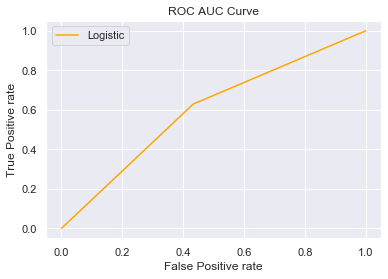

In [320]:
# Metrics for y_pred1
confusion_matrix1 = confusion_matrix(y_test,y_pred1)
print("The confusion matrix is: \n", confusion_matrix1)
fpr,tpr,thresholds = roc_curve(y_test,y_pred1)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc1 = roc_auc_score(y_test,y_pred1)
print("The auc score is: ",roc_auc1.round(3))

accuracy1 = accuracy_score(y_test,y_pred1)
print("The accuracy score is: ", accuracy1.round(3))

recall1 = recall_score(y_test,y_pred1)
print("The recall score is: ", recall1.round(3))

precision1 = precision_score(y_test,y_pred1)
print("The precision score is: ", precision1.round(3))

f1_score1 = f1_score(y_test,y_pred1)
print("F1 score is: ", f1_score1.round(3))

This first model is not very convincing:
- From the correlation matrix, we can see that False positive and False nefative errors are high. 
- All metrics are low and can be improved. 

# 2nd model 
- transfroming duration from millisecond to minutes
- creation of squared decade and drop decade
- standardizing chorus_hit (to standardize also tempo and squared decade was not convincing)
- putting a weight on the distance

In [321]:
X2 = df.drop(['track','artist','target','sections'],axis=1).copy()

In [322]:
# Feature engineering

# transfroming duration from millisecond to minutes
X2.duration_ms = ((X2.duration_ms/1000)/60).round(3)
# Standardizing chorus_hit
scaler = StandardScaler().fit(X2.chorus_hit.values.reshape(41106,1))
X2.chorus_hit = scaler.transform(X2.chorus_hit.values.reshape(41106,1))
# Standardizing tempo
scaler1 = StandardScaler().fit(X2.tempo.values.reshape(41106,1))
X2.tempo = scaler1.transform(X2.tempo.values.reshape(41106,1))
# Squared decade
X2['decade_squared'] = X2.decade.map(lambda x:x**2)

In [323]:
X2_train, X2_test, y_train, y_test = train_test_split(X2,y,test_size=0.33, stratify=y)

In [324]:
# Model 2
model2 = LogisticRegression(class_weight='balanced').fit(X2_train, y_train)
y_pred2 = model2.predict(X2_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



The confusion matrix is: 
 [[4460 2322]
 [1157 5626]]
The auc score is:  0.744
The accuracy score is:  0.744
The recall score is:  0.829
The precision score is:  0.708
F1 score is:  0.764


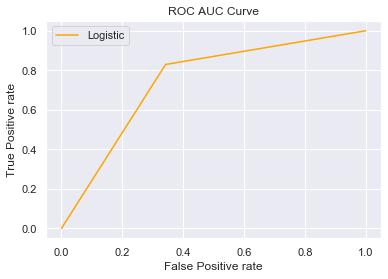

In [325]:
# Metrics for Model 2
confusion_matrix2 = confusion_matrix(y_test,y_pred2)
print("The confusion matrix is: \n", confusion_matrix2)
fpr,tpr,thresholds = roc_curve(y_test,y_pred2)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend( )

roc_auc2 = roc_auc_score(y_test,y_pred2)
print("The auc score is: ",roc_auc2.round(3))

accuracy2 = accuracy_score(y_test,y_pred2)
print("The accuracy score is: ", accuracy2.round(3))

recall2 = recall_score(y_test,y_pred2)
print("The recall score is: ", recall2.round(3))

precision2 = precision_score(y_test,y_pred2)
print("The precision score is: ", precision2.round(3))

f1_score2 = f1_score(y_test,y_pred2)
print("F1 score is: ", f1_score2.round(3))

This second model is better than the first one: less false positive, precision have increase from 0.62 to 0.7

I can analyse the coefficients of this model:

In [326]:
model2.coef_

array([[ 3.9001343 , -1.64611411,  0.00755965,  0.12773384,  0.38197581,
        -2.36035483, -1.7198817 , -3.25638418, -0.27140338, -0.23795064,
         0.06743534,  0.00957231,  0.21510362, -0.05559753, -0.76601212,
        -1.04890504, -1.69611121,  0.02957241]])

In [327]:
X2.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature', 'chorus_hit', 'decade', 'long_track',
       'short_track', 'decade_squared'],
      dtype='object')

# 3.2 K Nearest Neighbors

- with same feature engineering as Logistic Regression model
- optimal number of neighbors = 99
- with a weight on the distance 

In [298]:
# Model 3
model3 = KNeighborsClassifier(n_neighbors=99,weights='distance').fit(X2_train, y_train)
y_pred3 = model3.predict(X2_test)

The confusion matrix is: 
 [[2918 3864]
 [ 501 6282]]
The auc score is:  0.678
The accuracy score is:  0.678
The recall score is:  0.926
The precision score is:  0.619
F1 score is:  0.742


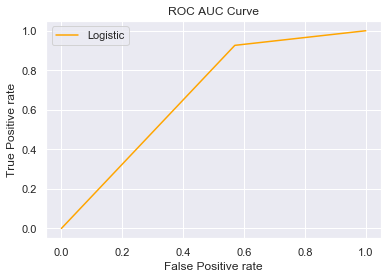

In [299]:
# Metrics for Model 3

confusion_matrix3 = confusion_matrix(y_test,y_pred3)
print("The confusion matrix is: \n", confusion_matrix3)
fpr,tpr,thresholds = roc_curve(y_test,y_pred3)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend( )

roc_auc3 = roc_auc_score(y_test,y_pred3)
print("The auc score is: ",roc_auc3.round(3))

accuracy3 = accuracy_score(y_test,y_pred3)
print("The accuracy score is: ", accuracy3.round(3))

recall3 = recall_score(y_test,y_pred3)
print("The recall score is: ", recall3.round(3))

precision3 = precision_score(y_test,y_pred3)
print("The precision score is: ", precision3.round(3))

f1_score3 = f1_score(y_test,y_pred3)
print("F1 score is: ", f1_score3.round(3))

This third model is worse than the previous one: precision decreased from 0.71 to 0.62
    The best model remains Linear Regression 1

# 3.3 Support Vector Machine

- With same feature engineering as Logistic Regression mode
- With nu = 0.6
- With gamma = 'scale'

In [302]:
# Model 4
model4 = NuSVC(nu=0.6, probability=True, gamma = 'scale').fit(X2_train, y_train)
y_pred4 = model4.predict(X2_test)

The confusion matrix is: 
 [[4160 2622]
 [ 666 6117]]
The auc score is:  0.758
The accuracy score is:  0.758
The recall score is:  0.902
The precision score is:  0.7
F1 score is:  0.788


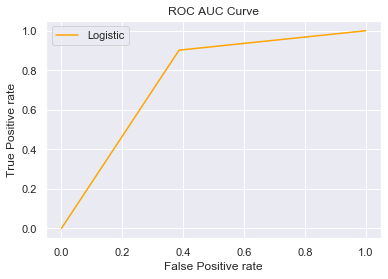

In [303]:
# Metrics for Model 4

confusion_matrix4 = confusion_matrix(y_test,y_pred4)
print("The confusion matrix is: \n", confusion_matrix4)
fpr,tpr,thresholds = roc_curve(y_test,y_pred4)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend( )

roc_auc4 = roc_auc_score(y_test,y_pred4)
print("The auc score is: ",roc_auc4.round(3))

accuracy4 = accuracy_score(y_test,y_pred4)
print("The accuracy score is: ", accuracy4.round(3))

recall4 = recall_score(y_test,y_pred4)
print("The recall score is: ", recall4.round(3))

precision4 = precision_score(y_test,y_pred4)
print("The precision score is: ", precision4.round(3))

f1_score4 = f1_score(y_test,y_pred4)
print("F1 score is: ", f1_score4.round(3))

The AUC score of this third model is slightly better the Logistic Regression model but not for the precision scores

# 3.4 Decision Tree Classifier

- with same feature engineering as Logistic Regression mode
- with a weight on the distance

In [304]:
# Model 5
model5 = DecisionTreeClassifier(class_weight='balanced').fit(X2_train, y_train)
y_pred5 = model5.predict(X2_test)

The confusion matrix is: 
 [[4932 1850]
 [1995 4788]]
The auc score is:  0.717
The accuracy score is:  0.717
The recall score is:  0.706
The precision score is:  0.721
F1 score is:  0.714


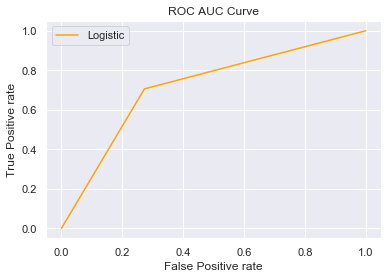

In [305]:
# Metrics for Model 5

confusion_matrix5 = confusion_matrix(y_test,y_pred5)
print("The confusion matrix is: \n", confusion_matrix5)
fpr,tpr,thresholds = roc_curve(y_test,y_pred5)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc5 = roc_auc_score(y_test,y_pred5)
print("The auc score is: ",roc_auc5.round(3))

accuracy5 = accuracy_score(y_test,y_pred5)
print("The accuracy score is: ", accuracy5.round(3))

recall5 = recall_score(y_test,y_pred5)
print("The recall score is: ", recall5.round(3))

precision5 = precision_score(y_test,y_pred5)
print("The precision score is: ", precision5.round(3))

f1_score5 = f1_score(y_test,y_pred5)
print("F1 score is: ", f1_score5.round(3))

This fourth model have the best precision score of all models.
However, this model is also known for sometimes overfitted. To find out, let's check the Random Forest Classifier. 

# 3.5 Random Forest Classifier

- with same feature engineering as Logistic Regression mode

In [306]:
# Model 6
model6 = RandomForestClassifier().fit(X2_train, y_train)
y_pred6 = model6.predict(X2_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



The confusion matrix is: 
 [[5327 1455]
 [1587 5196]]
The auc score is:  0.776
The accuracy score is:  0.776
The recall score is:  0.766
The precision score is:  0.781
F1 score is:  0.774


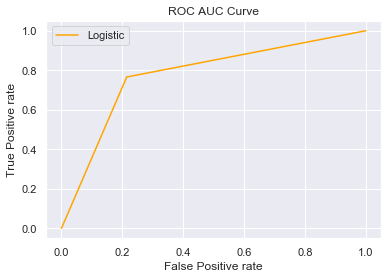

In [307]:
# Metrics for Model 6

confusion_matrix6 = confusion_matrix(y_test,y_pred6)
print("The confusion matrix is: \n", confusion_matrix6)
fpr,tpr,thresholds = roc_curve(y_test,y_pred6)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc6 = roc_auc_score(y_test,y_pred6)
print("The auc score is: ",roc_auc6.round(3))

accuracy6 = accuracy_score(y_test,y_pred6)
print("The accuracy score is: ", accuracy6.round(3))

recall6 = recall_score(y_test,y_pred6)
print("The recall score is: ", recall6.round(3))

precision6 = precision_score(y_test,y_pred6)
print("The precision score is: ", precision6.round(3))

f1_score6 = f1_score(y_test,y_pred6)
print("F1 score is: ", f1_score6.round(3))

The AUC score from Random Forest is higher than the AUC score from Decision Tree : Decision Tree was not overfitted. This model becomes the best model since we have a AUC score and a precision score at 0.78

# 3.6 Naive Bayes

- with same feature engineering as Logistic Regression mode

In [308]:
# Model 7 
model7 = GaussianNB().fit(X2_train, y_train)
y_pred7 = model7.predict(X2_test)

The confusion matrix is: 
 [[3518 3264]
 [ 743 6040]]
The auc score is:  0.705
The accuracy score is:  0.705
The recall score is:  0.89
The precision score is:  0.649
F1 score is:  0.751


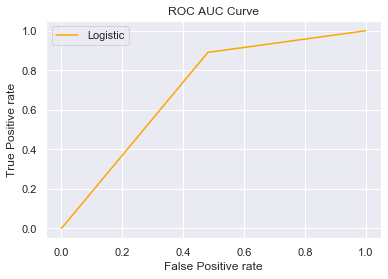

In [309]:
# Metrics for Model 7

confusion_matrix7 = confusion_matrix(y_test,y_pred7)
print("The confusion matrix is: \n", confusion_matrix7)
fpr,tpr,thresholds = roc_curve(y_test,y_pred7)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc7 = roc_auc_score(y_test,y_pred7)
print("The auc score is: ",roc_auc7.round(3))

accuracy7 = accuracy_score(y_test,y_pred7)
print("The accuracy score is: ", accuracy7.round(3))

recall7 = recall_score(y_test,y_pred7)
print("The recall score is: ", recall7.round(3))

precision7 = precision_score(y_test,y_pred7)
print("The precision score is: ", precision7.round(3))

f1_score7 = f1_score(y_test,y_pred7)
print("F1 score is: ", f1_score7.round(3))

This model is not better than the previous one.

# 3.7 Catboost

- with same feature engineering as Logistic Regression mode

In [310]:
# Model 8
model8 = CatBoostClassifier().fit(X2_train, y_train)
y_pred8 = model8.predict(X2_test)

Learning rate set to 0.042443
0:	learn: 0.6745087	total: 27.8ms	remaining: 27.8s
1:	learn: 0.6590193	total: 78.5ms	remaining: 39.2s
2:	learn: 0.6451641	total: 104ms	remaining: 34.6s
3:	learn: 0.6335488	total: 119ms	remaining: 29.6s
4:	learn: 0.6222480	total: 137ms	remaining: 27.2s
5:	learn: 0.6108054	total: 153ms	remaining: 25.4s
6:	learn: 0.6008765	total: 166ms	remaining: 23.5s
7:	learn: 0.5919298	total: 194ms	remaining: 24s
8:	learn: 0.5840586	total: 220ms	remaining: 24.2s
9:	learn: 0.5770558	total: 255ms	remaining: 25.2s
10:	learn: 0.5703310	total: 313ms	remaining: 28.1s
11:	learn: 0.5638615	total: 345ms	remaining: 28.4s
12:	learn: 0.5584768	total: 363ms	remaining: 27.6s
13:	learn: 0.5531385	total: 383ms	remaining: 27s
14:	learn: 0.5481681	total: 413ms	remaining: 27.1s
15:	learn: 0.5425272	total: 437ms	remaining: 26.9s
16:	learn: 0.5379782	total: 463ms	remaining: 26.8s
17:	learn: 0.5342279	total: 477ms	remaining: 26s
18:	learn: 0.5306373	total: 492ms	remaining: 25.4s
19:	learn: 0.52

160:	learn: 0.4212926	total: 3.36s	remaining: 17.5s
161:	learn: 0.4211168	total: 3.39s	remaining: 17.5s
162:	learn: 0.4208722	total: 3.41s	remaining: 17.5s
163:	learn: 0.4207045	total: 3.42s	remaining: 17.5s
164:	learn: 0.4203957	total: 3.44s	remaining: 17.4s
165:	learn: 0.4200559	total: 3.45s	remaining: 17.3s
166:	learn: 0.4199046	total: 3.46s	remaining: 17.3s
167:	learn: 0.4197311	total: 3.48s	remaining: 17.2s
168:	learn: 0.4195758	total: 3.5s	remaining: 17.2s
169:	learn: 0.4192756	total: 3.52s	remaining: 17.2s
170:	learn: 0.4190409	total: 3.54s	remaining: 17.1s
171:	learn: 0.4189205	total: 3.55s	remaining: 17.1s
172:	learn: 0.4186470	total: 3.56s	remaining: 17s
173:	learn: 0.4184287	total: 3.58s	remaining: 17s
174:	learn: 0.4181867	total: 3.6s	remaining: 17s
175:	learn: 0.4178940	total: 3.61s	remaining: 16.9s
176:	learn: 0.4176315	total: 3.62s	remaining: 16.9s
177:	learn: 0.4173735	total: 3.65s	remaining: 16.8s
178:	learn: 0.4169640	total: 3.7s	remaining: 17s
179:	learn: 0.4167397	t

325:	learn: 0.3891725	total: 6.07s	remaining: 12.5s
326:	learn: 0.3890141	total: 6.09s	remaining: 12.5s
327:	learn: 0.3887691	total: 6.1s	remaining: 12.5s
328:	learn: 0.3886180	total: 6.12s	remaining: 12.5s
329:	learn: 0.3883907	total: 6.13s	remaining: 12.4s
330:	learn: 0.3882214	total: 6.14s	remaining: 12.4s
331:	learn: 0.3880524	total: 6.15s	remaining: 12.4s
332:	learn: 0.3878932	total: 6.16s	remaining: 12.3s
333:	learn: 0.3877274	total: 6.18s	remaining: 12.3s
334:	learn: 0.3875686	total: 6.19s	remaining: 12.3s
335:	learn: 0.3874068	total: 6.2s	remaining: 12.3s
336:	learn: 0.3872658	total: 6.21s	remaining: 12.2s
337:	learn: 0.3871359	total: 6.22s	remaining: 12.2s
338:	learn: 0.3869615	total: 6.24s	remaining: 12.2s
339:	learn: 0.3868066	total: 6.25s	remaining: 12.1s
340:	learn: 0.3866355	total: 6.26s	remaining: 12.1s
341:	learn: 0.3865159	total: 6.28s	remaining: 12.1s
342:	learn: 0.3863996	total: 6.3s	remaining: 12.1s
343:	learn: 0.3862426	total: 6.31s	remaining: 12s
344:	learn: 0.386

490:	learn: 0.3659086	total: 8.31s	remaining: 8.62s
491:	learn: 0.3658214	total: 8.35s	remaining: 8.62s
492:	learn: 0.3656946	total: 8.37s	remaining: 8.61s
493:	learn: 0.3655922	total: 8.38s	remaining: 8.59s
494:	learn: 0.3654764	total: 8.4s	remaining: 8.57s
495:	learn: 0.3653718	total: 8.41s	remaining: 8.55s
496:	learn: 0.3652796	total: 8.42s	remaining: 8.52s
497:	learn: 0.3651234	total: 8.43s	remaining: 8.5s
498:	learn: 0.3649985	total: 8.45s	remaining: 8.48s
499:	learn: 0.3649029	total: 8.47s	remaining: 8.47s
500:	learn: 0.3647664	total: 8.48s	remaining: 8.45s
501:	learn: 0.3646440	total: 8.49s	remaining: 8.43s
502:	learn: 0.3645521	total: 8.51s	remaining: 8.4s
503:	learn: 0.3644512	total: 8.53s	remaining: 8.39s
504:	learn: 0.3643357	total: 8.56s	remaining: 8.39s
505:	learn: 0.3642290	total: 8.59s	remaining: 8.38s
506:	learn: 0.3641239	total: 8.62s	remaining: 8.38s
507:	learn: 0.3640020	total: 8.65s	remaining: 8.38s
508:	learn: 0.3638969	total: 8.67s	remaining: 8.36s
509:	learn: 0.3

659:	learn: 0.3468881	total: 11s	remaining: 5.68s
660:	learn: 0.3467804	total: 11.1s	remaining: 5.67s
661:	learn: 0.3467105	total: 11.1s	remaining: 5.65s
662:	learn: 0.3465969	total: 11.1s	remaining: 5.63s
663:	learn: 0.3465053	total: 11.1s	remaining: 5.61s
664:	learn: 0.3463512	total: 11.1s	remaining: 5.59s
665:	learn: 0.3462616	total: 11.1s	remaining: 5.58s
666:	learn: 0.3461501	total: 11.1s	remaining: 5.56s
667:	learn: 0.3460594	total: 11.1s	remaining: 5.54s
668:	learn: 0.3459414	total: 11.2s	remaining: 5.52s
669:	learn: 0.3458423	total: 11.2s	remaining: 5.5s
670:	learn: 0.3457396	total: 11.2s	remaining: 5.48s
671:	learn: 0.3456541	total: 11.2s	remaining: 5.46s
672:	learn: 0.3455873	total: 11.2s	remaining: 5.44s
673:	learn: 0.3454836	total: 11.2s	remaining: 5.42s
674:	learn: 0.3453833	total: 11.2s	remaining: 5.4s
675:	learn: 0.3452794	total: 11.2s	remaining: 5.39s
676:	learn: 0.3451633	total: 11.3s	remaining: 5.37s
677:	learn: 0.3450449	total: 11.3s	remaining: 5.36s
678:	learn: 0.34

818:	learn: 0.3317782	total: 13.6s	remaining: 3.01s
819:	learn: 0.3316686	total: 13.6s	remaining: 2.99s
820:	learn: 0.3316120	total: 13.6s	remaining: 2.98s
821:	learn: 0.3315602	total: 13.7s	remaining: 2.96s
822:	learn: 0.3315062	total: 13.7s	remaining: 2.94s
823:	learn: 0.3313976	total: 13.7s	remaining: 2.92s
824:	learn: 0.3313006	total: 13.7s	remaining: 2.9s
825:	learn: 0.3312099	total: 13.7s	remaining: 2.89s
826:	learn: 0.3311170	total: 13.7s	remaining: 2.87s
827:	learn: 0.3310355	total: 13.7s	remaining: 2.85s
828:	learn: 0.3309368	total: 13.7s	remaining: 2.83s
829:	learn: 0.3308325	total: 13.8s	remaining: 2.82s
830:	learn: 0.3307721	total: 13.8s	remaining: 2.8s
831:	learn: 0.3306511	total: 13.8s	remaining: 2.78s
832:	learn: 0.3305550	total: 13.8s	remaining: 2.77s
833:	learn: 0.3304754	total: 13.8s	remaining: 2.75s
834:	learn: 0.3303887	total: 13.8s	remaining: 2.73s
835:	learn: 0.3303096	total: 13.9s	remaining: 2.72s
836:	learn: 0.3302053	total: 13.9s	remaining: 2.7s
837:	learn: 0.3

989:	learn: 0.3174161	total: 16.1s	remaining: 163ms
990:	learn: 0.3173099	total: 16.1s	remaining: 147ms
991:	learn: 0.3172120	total: 16.1s	remaining: 130ms
992:	learn: 0.3171460	total: 16.2s	remaining: 114ms
993:	learn: 0.3170773	total: 16.2s	remaining: 97.6ms
994:	learn: 0.3169699	total: 16.2s	remaining: 81.3ms
995:	learn: 0.3168866	total: 16.2s	remaining: 65ms
996:	learn: 0.3167894	total: 16.2s	remaining: 48.8ms
997:	learn: 0.3167107	total: 16.2s	remaining: 32.5ms
998:	learn: 0.3166187	total: 16.2s	remaining: 16.2ms
999:	learn: 0.3165230	total: 16.2s	remaining: 0us


The confusion matrix is: 
 [[5248 1534]
 [ 915 5868]]
The auc score is:  0.819
The accuracy score is:  0.819
The recall score is:  0.865
The precision score is:  0.793
F1 score is:  0.827


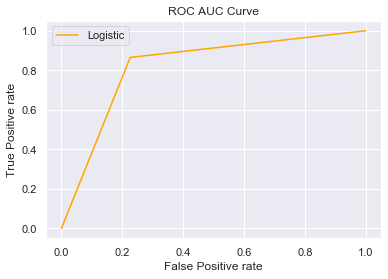

In [311]:
# Metrics for Model 8

confusion_matrix8 = confusion_matrix(y_test,y_pred8)
print("The confusion matrix is: \n", confusion_matrix8)
fpr,tpr,thresholds = roc_curve(y_test,y_pred8)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend( )

roc_auc8 = roc_auc_score(y_test,y_pred8)
print("The auc score is: ",roc_auc8.round(3))

accuracy8 = accuracy_score(y_test,y_pred8)
print("The accuracy score is: ", accuracy8.round(3))

recall8 = recall_score(y_test,y_pred8)
print("The recall score is: ", recall8.round(3))

precision8 = precision_score(y_test,y_pred8)
print("The precision score is: ", precision8.round(3))

f1_score8 = f1_score(y_test,y_pred8)
print("F1 score is: ", f1_score8.round(3))

This last model have the highest AUC score and highest precision score compared to all the other models.

# 3.8 Model comparaison

In [399]:
pd.DataFrame({
    "Model": ["Logistic Regression1", "Logistic Regression2", "K Nearest Neighbors","SVM","Decision Tree", 
              "Random Forest","Naive Bayes","Catboost"],
    "Roc Auc": [eval(f'roc_auc{i}') for i in range(1,9)],
    "Accuracy": [eval(f'accuracy{i}') for i in range(1,9)],
    "Recall": [eval(f'recall{i}') for i in range(1,9)],
    "Precision": [eval(f'precision{i}') for i in range(1,9)],
    "F1 score": [eval(f'f1_score{i}') for i in range(1,9)],
}).round(3)


,Model,Roc Auc,Accuracy,Recall,Precision,F1 score
0,Logistic Regression1,0.598,0.598,0.629,0.592,0.610
1,Logistic Regression2,0.744,0.744,0.829,0.708,0.764
2,K Nearest Neighbors,0.678,0.678,0.926,0.619,0.742
3,SVM,0.758,0.758,0.902,0.700,0.788
4,Decision Tree,0.717,0.717,0.706,0.721,0.714
5,Random Forest,0.776,0.776,0.766,0.781,0.774
6,Naive Bayes,0.705,0.705,0.890,0.649,0.751
7,Catboost,0.819,0.819,0.865,0.793,0.827


So far, the best model to predict hits on Spotify is Catboost regarding the AUC score and the precision score. 

# 3.9 Analysing Catboost contributions from features

SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value.

For this model, features that have a higher impact to classify a track to hit or non hit are :

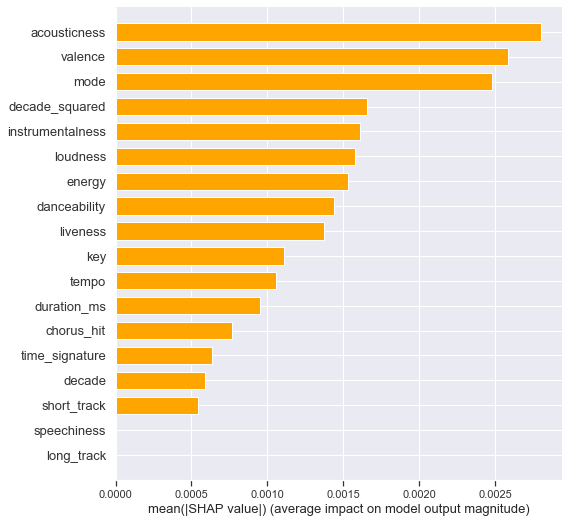

In [406]:
shap.summary_plot(shap_values, X2, plot_type="bar",color='orange')

To go further, we could ask this question : how much was a prediction driven by the fact that the valence was equal to 1, instead of other values of valance ? To answer to this question, we can built a force plot. 

We predicted 0.01, whereas the base_value is 0.00002482.\
Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. \
Here, the biggest impact comes from valence being 0.89. Though the accousticness value has a meaningful effect, it decreasing the prediction.

In [398]:
shap_values = model8.get_feature_importance(Pool(X2_test, label=y_test,cat_features=categorical_features_indices),type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X2_test.iloc[3,:])


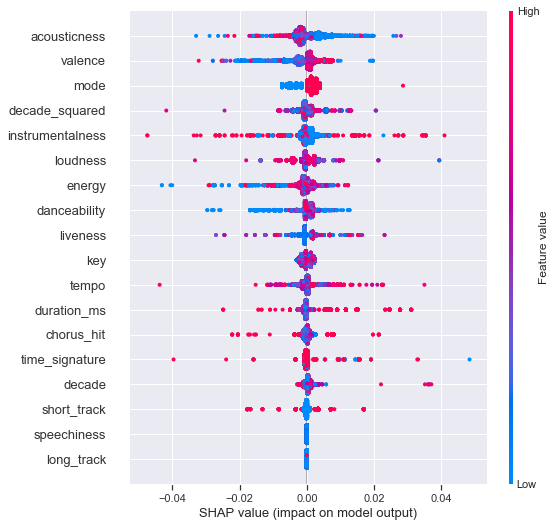

In [369]:
shap.summary_plot(shap_values, X2_test)

# 4. Supervized learning models with 'Principal Component Analysis' (PCA)

- same feature engineering than the other models but without squared decade

In [370]:
X3 = df.drop(['track','artist','target','sections'],axis=1).copy()
y = df.target.copy()

In [371]:
# transfroming duration from millisecond to minutes
X3.duration_ms = ((X3.duration_ms/1000)/60).round(3)
# Standardizing chorus_hit
scaler = StandardScaler().fit(X3.chorus_hit.values.reshape(41106,1))
X3.chorus_hit = scaler.transform(X3.chorus_hit.values.reshape(41106,1))
# Standardizing tempo
scaler1 = StandardScaler().fit(X2.tempo.values.reshape(41106,1))
X2.tempo = scaler1.transform(X2.tempo.values.reshape(41106,1))

In [372]:
X3_train, X3_test, y_train, y_test = train_test_split(X3,y,test_size=0.33, stratify=y)

In [373]:
pca = PCA(2)
pca.fit(X3_train)
X3_PCA = pca.transform(X3_train)

In [374]:
pca.explained_variance_ratio_

array([0.94580905, 0.03072331])

Text(0, 0.5, 'Second Principal Component')

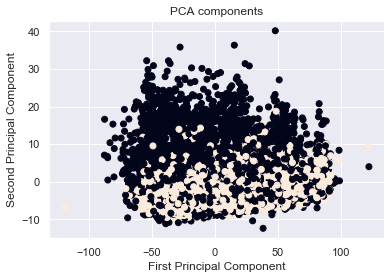

In [375]:
scatter = plt.scatter(X3_PCA[:,0], X3_PCA[:,1], c=y_train)
plt.title('PCA components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

We can see that the separation between the hits and non hits is not very clear.\
Building models with PCA feature engineering may not be convincing, but let's test it anyway.

# 4.1 Logistic regression

In [376]:
# Model 9
model9 = LogisticRegression(class_weight='balanced').fit(X3_PCA,y_train)
y_pred9 = model9.predict(pca.transform(X3_test))

The confusion matrix is: 
 [[3705 3078]
 [2407 4375]]
The auc score is:  0.596
The accuracy score is:  0.596
The recall score is:  0.645
The precision score is:  0.587
F1 score is:  0.615


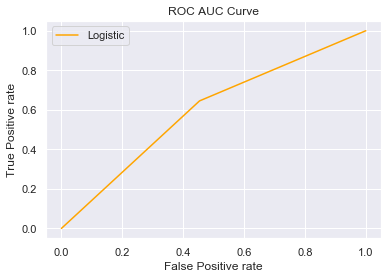

In [377]:
# Metrics for Model 9

confusion_matrix9 = confusion_matrix(y_test,y_pred9)
print("The confusion matrix is: \n", confusion_matrix9)
fpr,tpr,thresholds = roc_curve(y_test,y_pred9)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend( )

roc_auc9 = roc_auc_score(y_test,y_pred9)
print("The auc score is: ",roc_auc9.round(3))

accuracy9 = accuracy_score(y_test,y_pred9)
print("The accuracy score is: ", accuracy9.round(3))

recall9 = recall_score(y_test,y_pred9)
print("The recall score is: ", recall9.round(3))

precision9 = precision_score(y_test,y_pred9)
print("The precision score is: ", precision9.round(3))

f1_score9 = f1_score(y_test,y_pred9)
print("F1 score is: ", f1_score9.round(3))

# 4.2 K Nearest Neighbors

In [378]:
# Model 10
model10 = KNeighborsClassifier(n_neighbors=99,weights='distance').fit(X3_PCA,y_train)
y_pred10 = model10.predict(pca.transform(X3_test))

The confusion matrix is: 
 [[3384 3399]
 [1932 4850]]
The auc score is:  0.607
The accuracy score is:  0.607
The recall score is:  0.715
The precision score is:  0.588
F1 score is:  0.645


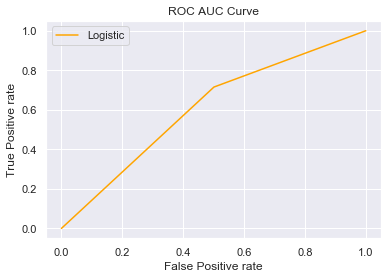

In [379]:
# Metrics for Model 10

confusion_matrix10 = confusion_matrix(y_test,y_pred10)
print("The confusion matrix is: \n", confusion_matrix10)
fpr,tpr,thresholds = roc_curve(y_test,y_pred10)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc10 = roc_auc_score(y_test,y_pred10)
print("The auc score is: ",roc_auc10.round(3))

accuracy10 = accuracy_score(y_test,y_pred10)
print("The accuracy score is: ", accuracy10.round(3))

recall10 = recall_score(y_test,y_pred10)
print("The recall score is: ", recall10.round(3))

precision10 = precision_score(y_test,y_pred10)
print("The precision score is: ", precision10.round(3))

f1_score10 = f1_score(y_test,y_pred10)
print("F1 score is: ", f1_score10.round(3))

# 4.3 Support Vector Machine

In [380]:
# Model 11
model11 = SVC().fit(X3_PCA,y_train)
y_pred11 = model11.predict(pca.transform(X3_test))

The confusion matrix is: 
 [[3226 3557]
 [1796 4986]]
The auc score is:  0.605
The accuracy score is:  0.605
The recall score is:  0.735
The precision score is:  0.584
F1 score is:  0.651


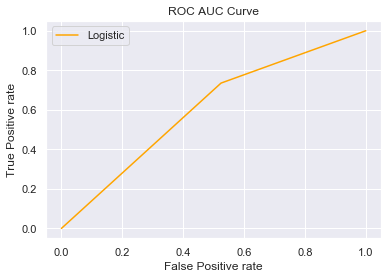

In [381]:
# Metrics for Model 11

confusion_matrix11 = confusion_matrix(y_test,y_pred11)
print("The confusion matrix is: \n", confusion_matrix11)
fpr,tpr,thresholds = roc_curve(y_test,y_pred11)
plt.plot(fpr,tpr, label='Logistic', color="orange")
plt.title('ROC AUC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()

roc_auc11 = roc_auc_score(y_test,y_pred11)
print("The auc score is: ",roc_auc11.round(3))

accuracy11 = accuracy_score(y_test,y_pred11)
print("The accuracy score is: ", accuracy11.round(3))

recall11 = recall_score(y_test,y_pred11)
print("The recall score is: ", recall11.round(3))

precision11 = precision_score(y_test,y_pred11)
print("The precision score is: ", precision11.round(3))

f1_score11 = f1_score(y_test,y_pred11)
print("F1 score is: ", f1_score11.round(3))

# 4.4 Model comparaison

In [401]:
pd.DataFrame({
    "Model": ["Logistic Regression1", "Logistic Regression2", "K Nearest Neighbors","SVM","Decision Tree", 
              "Random Forest","Naive Bayes","Catboost","Logistic Regression with PCA",
              "K Nearest Neighbors with PCA","SVM with PCA"],
    "Roc Auc": [eval(f'roc_auc{i}') for i in range(1,12)],
    "Accuracy": [eval(f'accuracy{i}') for i in range(1,12)],
    "Recall": [eval(f'recall{i}') for i in range(1,12)],
    "Precision": [eval(f'precision{i}') for i in range(1,12)],
    "F1 score": [eval(f'f1_score{i}') for i in range(1,12)],
}).round(3)

,Model,Roc Auc,Accuracy,Recall,Precision,F1 score
0,Logistic Regression1,0.598,0.598,0.629,0.592,0.610
1,Logistic Regression2,0.744,0.744,0.829,0.708,0.764
2,K Nearest Neighbors,0.678,0.678,0.926,0.619,0.742
3,SVM,0.758,0.758,0.902,0.700,0.788
4,Decision Tree,0.717,0.717,0.706,0.721,0.714
5,Random Forest,0.776,0.776,0.766,0.781,0.774
6,Naive Bayes,0.705,0.705,0.890,0.649,0.751
7,Catboost,0.819,0.819,0.865,0.793,0.827
8,Logistic Regression with PCA,0.596,0.596,0.645,0.587,0.615
9,K Nearest Neighbors with PCA,0.607,0.607,0.715,0.588,0.645


In [397]:
pd.DataFrame({
    "Model": ["Logistic Regression1", "Logistic Regression2", "K Nearest Neighbors","SVM","Decision Tree", 
              "Random Forest","Naive Bayes","Catboost","Logistic Regression with PCA",
              "K Nearest Neighbors with PCA","SVM with PCA"],
    "Roc Auc": [eval(f'roc_auc{i}') for i in range(1,12)],
    "Accuracy": [eval(f'accuracy{i}') for i in range(1,12)],
    "Recall": [eval(f'recall{i}') for i in range(1,12)],
    "Precision": [eval(f'precision{i}') for i in range(1,12)],
    "F1 score": [eval(f'f1_score{i}') for i in range(1,12)],
}).round(3)

,Model,Roc Auc,Accuracy,Recall,Precision,F1 score
0,Logistic Regression1,0.598,0.598,0.629,0.592,0.610
1,Logistic Regression2,0.744,0.744,0.829,0.708,0.764
2,K Nearest Neighbors,0.678,0.678,0.926,0.619,0.742
3,SVM,0.758,0.758,0.902,0.700,0.788
4,Decision Tree,0.717,0.717,0.706,0.721,0.714
5,Random Forest,0.776,0.776,0.766,0.781,0.774
6,Naive Bayes,0.705,0.705,0.890,0.649,0.751
7,Catboost,0.819,0.819,0.865,0.793,0.827
8,Logistic Regression with PCA,0.596,0.596,0.645,0.587,0.615
9,K Nearest Neighbors with PCA,0.607,0.607,0.715,0.588,0.645


# 5. Summary

With Catboost, we are able to predict a song's success by 81%, which is not that bad, but False positive errors remain high. 


This is partly due to the dataset that brings together songs of all styles, and from all eras. I didn't have any genre criteria, or year to try and specialize my model on categories of songs.


So it's a universal model, necessarily moderately successful over the entire world music catalogue.
